CSC 630/1 Zufelt <br>
Michelle Chao, Sam Xifaras, Darius Lam, Moe Sunami, Diva Harsoor

# Catalog Card Processing
Creating a training dataset for object character recognition in order to read catalog cards (Robert S. Peabody Museum of Archaeology, 1930s to 1970s)
___

Given scanned PDFs of typewritten catalog cards, our goal is to create a dataset in which each row is a set of images of each character in a card.<br> <br>
Tasks: 
<ul>
    <li>Convert PDFs to TIFFs</li>
    <li>Cut the images into different sections corresponding to data type </li>
    <li>Cut the images into characters and add each image as a row of a DataFrame </li>
    <li>Label the DataFrame with the proper character labels</li>
    <li>Write a script that presents a user with a randomly generated row/image and its corresponding label (to check for accuracy)</li>
    <li>Display the process in this Jupyter Notebook</li>
</ul>

&ast;_Not all of these tasks were accomplished in the stated manner._ <br>
&ast;&ast;_Actually very few of them were._
___

## PDF to TIFF

In [1]:
import numpy as np
import subprocess
from PIL import Image
import cv2 #used for Otsu's Thresholding
import os
from skimage import io
from skimage import segmentation
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import re
%matplotlib inline

The functions below make calls to the following script, `util.sh`, which performs two important functions. First, the `merge` function, meant to be performed only once, moves all of the pdfs from their respective Acc. No. directories to the parent directory, `Accession Files`. This was more for convenience, because dealing with file names with spaces in bash is a hassle, and the accession numbers are indicated in the filenames, so we aren't losing any information when doing this.

Here is the code:
   
```
# util.sh

if [ "$1" == "merge" ]
then
    pushd "$2"
    for f in *
    do
        echo "Moving files from $f"
        pushd "$f"
        cp * ../ -fpv
        popd
        
        echo "Removing $f"
        rm "$f" -fR
    done 
    popd

elif [ "$1" == "convert" ]
then

    ACCNO=$2
    CATNO=$3

    # This is the path to the peabody_files directory
    ROOT=$4

    # Path to the ghostscript executable
    GS=$5

    pushd "${ROOT}"

    "$GS" -dNOPAUSE -r300 -sDEVICE=tiffscaled24 -sCompression=lzw -dBATCH -sOutputFile=${ACCNO}_${CATNO}.tif ${ACCNO}_${CATNO}.pdf

    popd

fi 




```

In [14]:
def merge(acc_files_dir='peabody_files/Accession Files'):
    
    """
    Moves all the pdfs to the parent directory, so that all the pdfs are in one directory, 
    and deletes all the 'Acc. No.' directories.
    """
    return subprocess.call(["sh", "util.sh", "merge", acc_files_dir])

def convert(acc_no, cat_no, gs_exec, acc_files_dir='peabody_files/Accession Files'):

    # Convert a specified pdf to tif
    subprocess.call(["sh", "util.sh", "convert", str(acc_no), str(cat_no).zfill(4), acc_files_dir, gs_exec])
    
    FNAME = str(acc_no) + '_' + str(cat_no).zfill(4)
    # Open the tif as a pillow object, delete the tif file, and return it
    
    tif = Image.open(acc_files_dir + '/' + FNAME + '.tif')
    
    subprocess.call(['rm', FNAME + '.tif'])
    
    return tif

In [5]:
# Run this if the pdfs are still organized into their respective directories.
# merge()

0

In [15]:
# Example of opening an image
img = convert(1, 2, 'C:/Program Files/gs/gs9.20/bin/gswin64c.exe')

___
We decided to use Otsu's Thresholding to binarize the image into only black and white pixels. It searches for the threshold that minimizes interclass variance - the class here are black pixels and white pixels. It determines the threshold with a weighted probability; then, it assigns all the pixels over the threshold the value `1` and all those below the value `0`.

We used the OpenCV module to apply Otsu's Thresholding method on the images. The following command allowed us to install OpenCV:
* conda install --channel https://conda.anaconda.org/menpo opencv3



These cells apply Otsu's Thresholding method to binarize the images, which are saved in a new folder called `peabody_files_otsu`. (folder is on Google Drive).
Afterwards, we use the Scikit-Image library to crop the images.

In [ ]:
import numpy as np
from PIL import Image
import cv2
import os
from skimage import io
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import re
%matplotlib inline

In [ ]:
def otsu_threshold(im_path):
    im = Image.open(im_path)
    im = cv2.cvtColor(np.array(im),cv2.COLOR_RGB2GRAY)
    im = im[10:im.shape[0]-10,10:im.shape[1]-10]
    height,width = im.shape
    t, d = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return d

In [ ]:
acc_nums = ['1','2','3','4','5','6','7','16','17','18','20','21','22','23','24','25']

The following two cells create the new folder containing the binarized images.

In [ ]:
save_folder = ("peabody_files_otsu")
os.mkdir(save_folder)
os.mkdir("peabody_files_otsu/Accession_Files")

In [ ]:
rootdir = 'peabody_files/Accession_Files'

for acc_no in acc_nums:
    ## Creates new folder to save files in
    new_folder_path = "peabody_files_otsu/Accession_Files/Acc._No._" + str(acc_no)
    os.mkdir(new_folder_path)
    
    ## Finding image
    path = rootdir + "/Acc._No._" + str(acc_no)
    for file,subdir,filelist in os.walk(path):
        for image_name in filelist:
            image_path = path + "/" + image_name
            image_save_name = image_name + ".png"
            save_path = new_folder_path + "/" + image_save_name
            cv2.imwrite(save_path,otsu_threshold(image_path))

___

## Segmentation

We have a few different ideas about how to separate out each character. Some of those processes work better with only one line of text (rather than text that wraps) and will interpret the black section boxes as individual characters. For ease down the line, we decided to store each card as a dictionary of section names and the cropped image of the corresponding data. <br><br>
In the next cells we use skimage to crop the binarized images, and save these pieces into a dictionary.

In [ ]:
def crop_image(sk_im):
    'Takes a skimage image file and crops the image, returns a dictionary of the pieces.'
    pieces = {}
    left_box = sk_im[5:600,5:420]
    length,height = left_box.shape[1],int(left_box.shape[0]/4)
    left_box_pieces = [left_box[i*height-height:i*height,0:length] for i in range(1,5)]
    
    right_box = sk_im[5:600,470:1770]
    length,height = right_box.shape[1], int(right_box.shape[0]/4)
    right_box_pieces = [right_box[i*height-height:i*height,0:length] for i in range(1,5)]
    
    bottom_box = sk_im[620:1100,10:1775]
    length,height = bottom_box.shape[1],int(bottom_box.shape[0]/4)
    bottom_box_pieces = [bottom_box[i*height-height:i*height,0:length] for i in range(1,4)]
    
    names = ['cat_no','acc_no','orig_no','photo_no']
    pieces.update(dict(zip(names,left_box_pieces)))
    
    names = ['name','site','site_no','locality']
    pieces.update(dict(zip(names,right_box_pieces)))
    
    names = ['situation','remarks','figured']
    pieces.update(dict(zip(names,bottom_box_pieces)))
    
    return pieces

In [ ]:
rootdir = 'peabody_files_otsu/Accession_Files'
filed_dict = {} ## each key contains an array of the dictionaries of cropped images
total_array = [] ## contains all dictionaries of cropped images, not filed
for acc_no in acc_nums:
    path = rootdir + "/Acc._No._" + str(acc_no)
    folder = []
    for file,subdir,filelist in os.walk(path):
        for image_name in filelist:
            image_path = path + "/" + image_name
            image = io.imread(image_path)
            ### if you want `folder` to be a dictionary with keys of image names eg. key = 1_0016
            
            # folder = {} 
            # folder[re.sub("[\w.]","",image_name)] = crop_image(image)
            
            ### otherwise folder is an array
            
            folder.append(crop_image(image)) 
            
    total_array.append(folder)
    filed_dict[acc_no] = folder

The above cell goes through all of the binarized images in each accession-number folder. In each accession-number folder, all of the images are cropped by the labels on the images. The pieces of these images can be accessed through a dictionary, where the keys are the labels on the image. There is one dictionary per image. Then, the dictionaries for each image under an accession number are added into an array. This array can be accessed through the dictionary called `filed_dict`.

If we want to see the piece containing `name` in the first image in the Accession No. 1 folder, for example, we can use the following code.

In [ ]:
io.imshow(filed_dict['1'][0]['name'],cmap='gray',vmin=0,vmax=225)
plt.show()

___
The idea was this: since the thresholding removes a lot of the background, all we needed to do now was find an algorithm that segmented joined pixel values well, because each character should be separated by white-space.  

This is the code for segmenting a thresholded image into its component characters. So to do this, we first load our thresholded image 'test.png', and then run the skimage.segmentation.felzenszwalb method on it.  This performs Felzenszwalb image segmentation, which is a fast-graph based method that returns more globular and restrained results than SLIC or quickshift.  Scale incfluences segment size, sigma is the width of the gaussian kernel used for processing (smaller sigma = smaller regions), and min_size is the minimum component size. 

The parameters I used work well on the test image.  The returned result is an integer image, where each integer from 0-np.max(seg) is a separate segmentation label. The method bbox2(img) returns the xmin,xmax,ymin,ymax of the bounding box for positive pixels.  We use this because each label is the only thing in the image, so the bbox method will return the bounding box coords for only the segmentated section.  Then we can show the segmented section from the original image.

(1155, 1759)

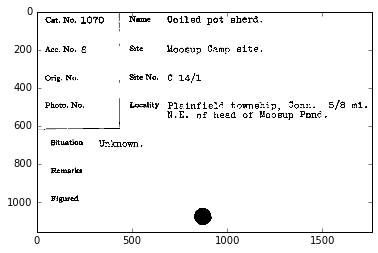

In [4]:
image = plt.imread('test.png')
plt.imshow(image,cmap=plt.cm.gray)
image.shape

477


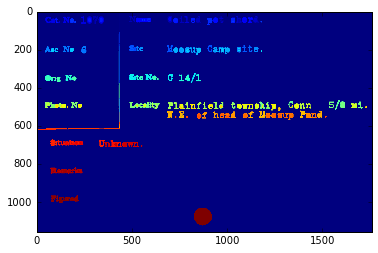

In [5]:
seg = segmentation.felzenszwalb(image,scale=5,sigma=.25,min_size=50)
plt.imshow(seg)
print(np.max(seg))

/Users/Darius/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


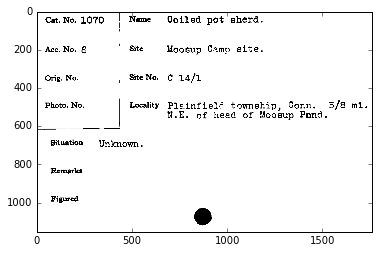

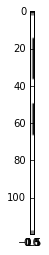

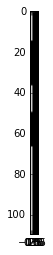

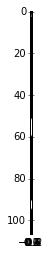

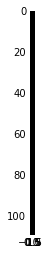

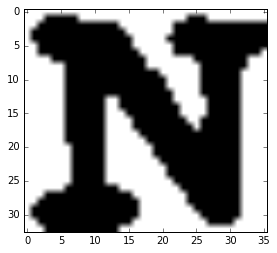

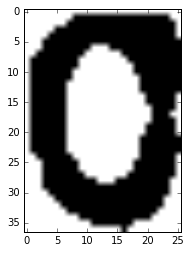

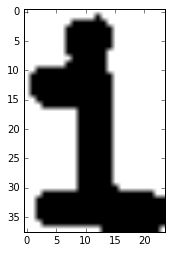

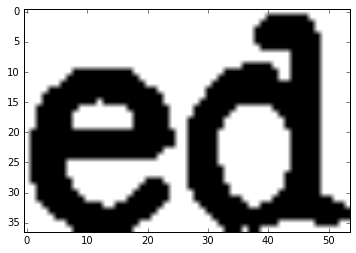

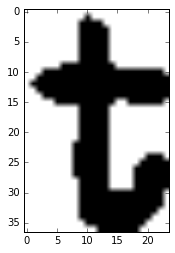

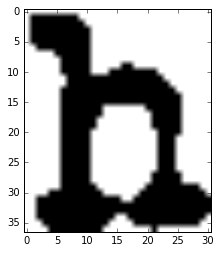

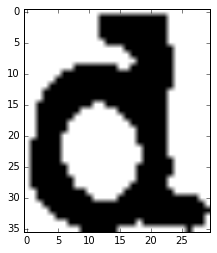

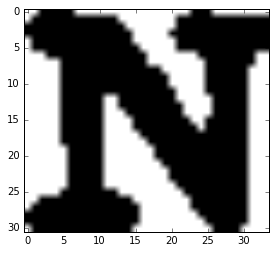

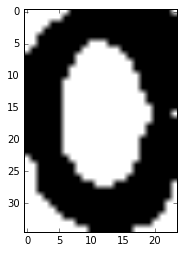

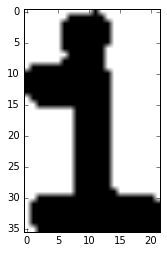

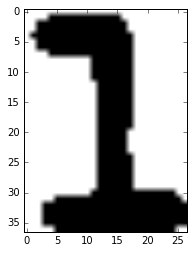

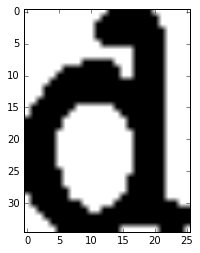

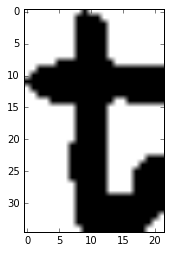

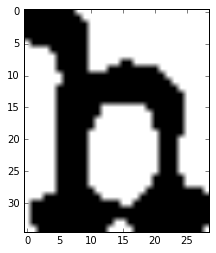

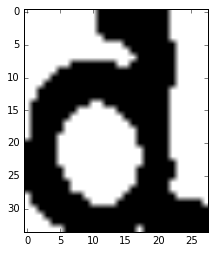

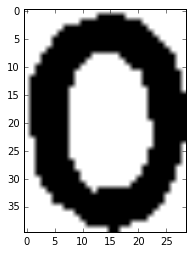

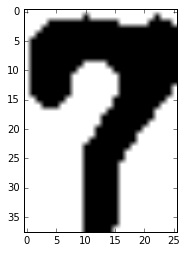

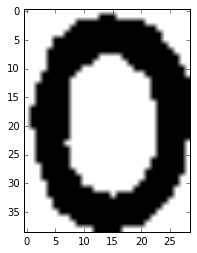

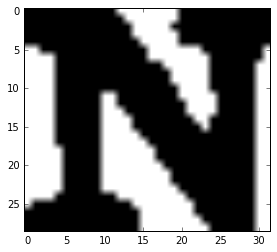

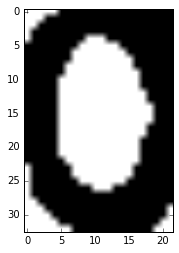

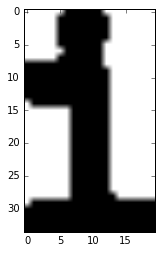

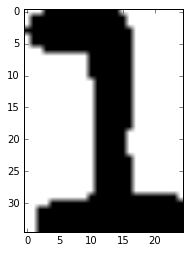

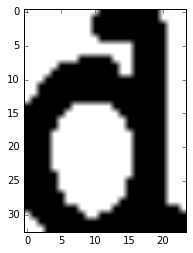

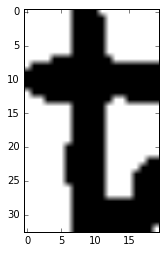

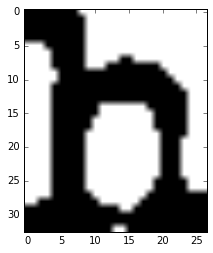

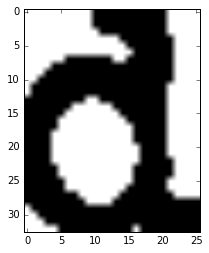

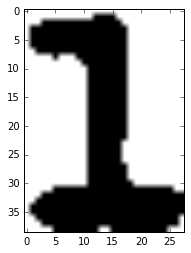

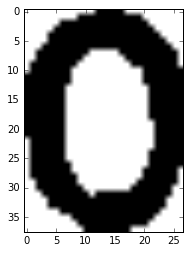

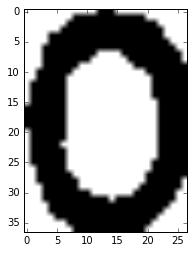

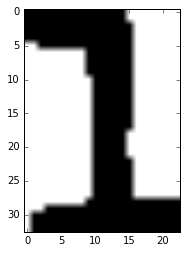

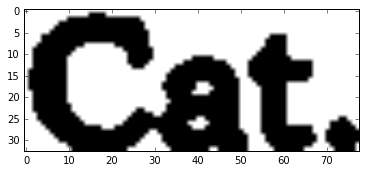

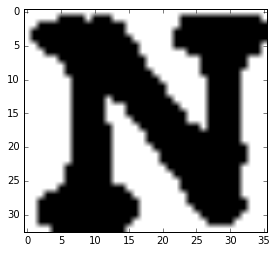

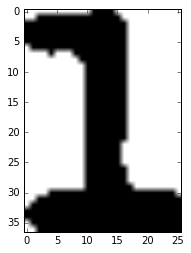

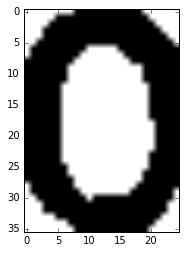

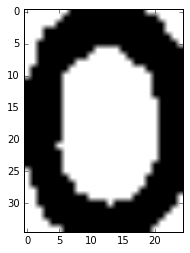

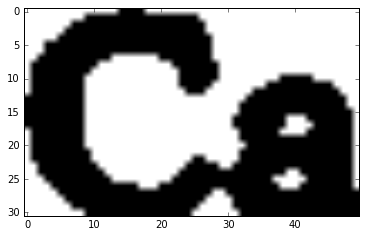

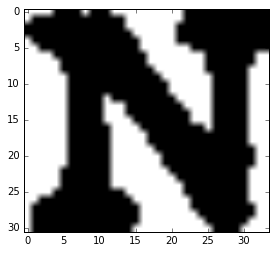

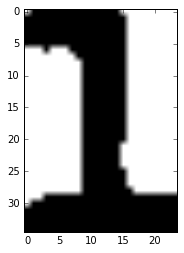

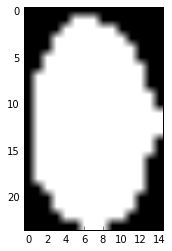

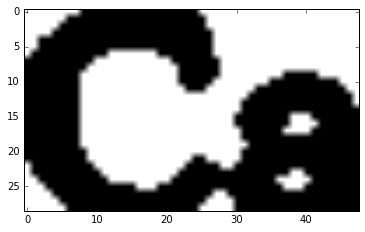

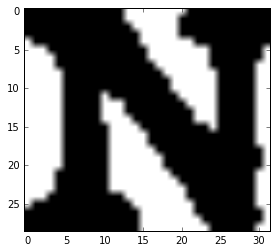

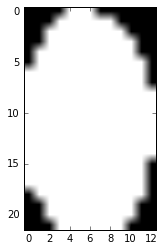

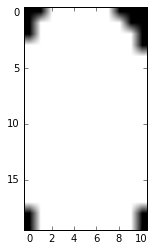

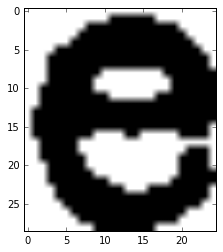

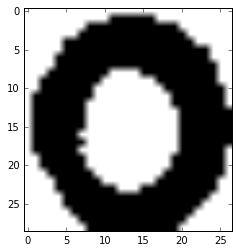

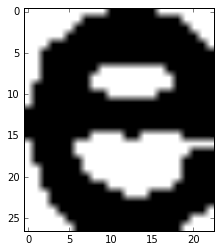

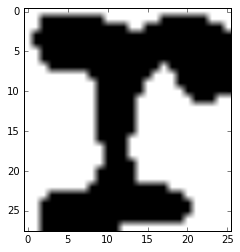

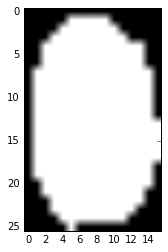

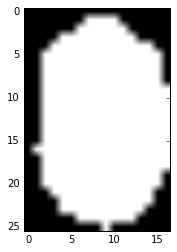

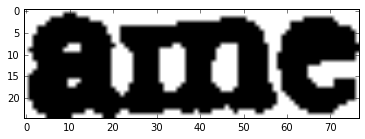

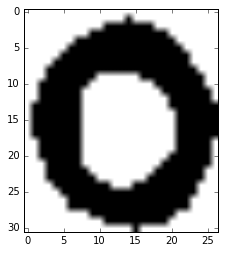

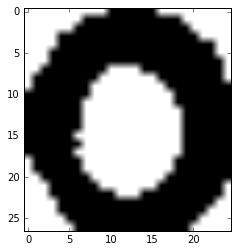

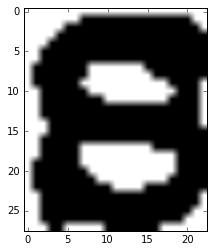

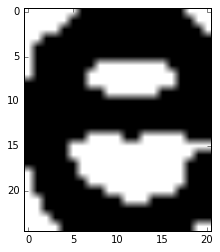

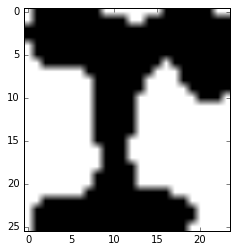

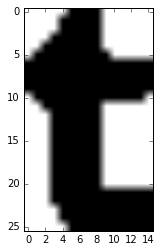

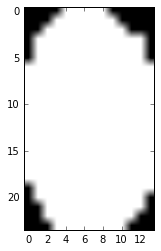

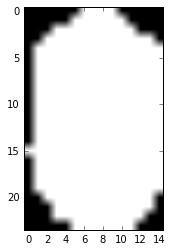

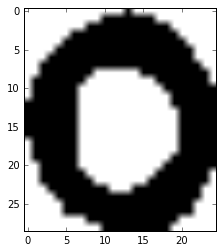

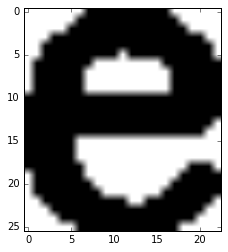

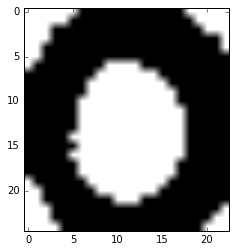

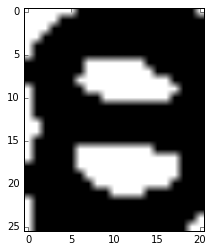

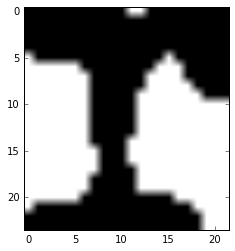

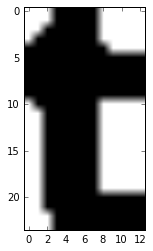

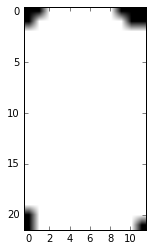

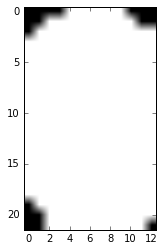

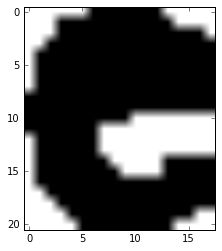

In [6]:
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

for i in range(72):
    x1,x2,y1,y2 = bbox2(seg==i)
    plt.figure(i)
    plt.imshow(image[x1:x2,y1:y2],cmap=plt.cm.gray)

The code below uses the seg array from above in order to show a labeling interface for users.  It then prints out images that were selected positive from the user.

In [7]:
from IPython.display import clear_output

buf = 3
p = []
for i in range(441):
    x1,x2,y1,y2 = bbox2(seg==i)
    p.append(image[x1-buf:x2+buf,y1-buf:y2+buf])

labels = []
for i in range(len(p)):
    plt.imshow(p[i],cmap=plt.cm.gray)
    plt.show()
    labels.append(input("What character is this? (Enter -1 for unrecognizable or double character)"))
    clear_output()
    if i == 10:
        break


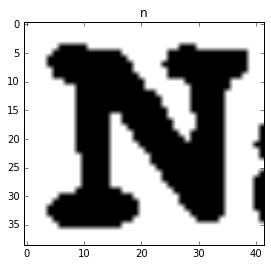

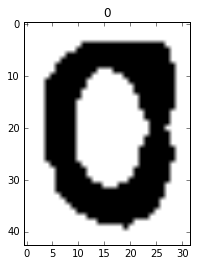

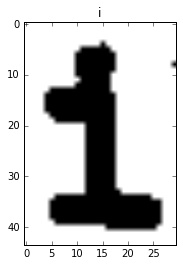

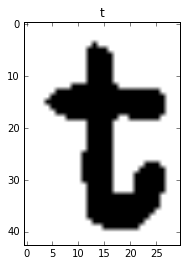

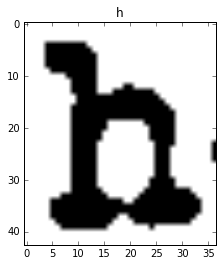

In [11]:
images = np.where(np.array(labels) != '-1')[0]
for i in images:
    plt.imshow(p[i],cmap=plt.cm.gray)
    plt.title(labels[i])
    plt.show()

___
Another initial idea we had to accomplish this same task was to use clustering. DBSCAN, or density based spatial clustering of applications with noise, determines clusters to be closely packed together items. In plain English: DBSCAN needs a dataset, a way to calculate distance, a threshold to determine whether that distance to close enough or too far, and a number of points to determine if there are enough points in close enough together to start a new cluster. It has the benefit of being very robust to outliers ("low density" areas). Unfortunately, it is a very slow and expensive algorithm (or the version of it that tried to implement was anyway). The following is the preliminary code, heavily commented.

In [ ]:
# requires a previously declared dictionary "data_set", formatted "(x,y):(x,y,bool)"
clusters = [] # a list of lists of (x,y)s that belong to a single character (hopefully)
def DBSCAN():
    # marks items as classified
    for key,value in data_set.items():
        if value[2] == False:
            value[2] = True
            # address noise
            if (len(neighbors(key)) >= min_pts):
                # new cluster
                cur = []
                clusters.append(cur);
                cur.append(key);
                fillClusters(key, len(clusters) - 1);

def fillClusters(item, i):
    neighboring = neighbors(item)
    for key,value in neighboring.items():
        if value[2] == False:
            value[2] = True
            # I'm worried that this is going to give us cluster of 7 or less pixels
            if len(neighbors(neighboring[i])) >= min_pts:
                neighboring += neighbors(neigbors[i])
            
def neighbors(item):
    neighboring = []
    for i in range(min(0,item[0]-1), max(item[0]+1,x_max):
        for j in range(min(0, item[1]-1), max(item[1]+1,y_max):
            if (i,j) in data_set:
                neighboring.append(data_set[(i,j)])
    return neighboring

___
## Labeling
The next task is to connect the segmented character images with their corresponding letter. We hoped to do that by cycling through the CSV data and character images, assigning each character in the CSV data to the character image in the same sequential order. The CSV data, however, did not correspond to the data on the cards well enough to be reliable.

### Cleaning Manually Typed In Data by WD Students
For years, work duty students have courageously attempted to type in data from peabody cards into a spreadsheet. Their labor is central to our OCR endeavor. Yet the data given to us by the Peabody is muddy. Work Duty students are generally exhausted and disinterested.

### Finding the CSV

In [ ]:
# The root path of the directory
# i.e., the folder containing all files related to this project. 
root_path = os.getcwd()
os.listdir(root_path)

In [ ]:
data_path = os.path.join(root_path, 'peabody_files')
os.listdir(data_path)

`Accession Files` contain PDFs, but what is the csv?
#### Examining the CSV and Identifying Relevant Columns
##### Examining CSV

In [ ]:
csv_name = os.listdir(data_path)[2]
ext_df = pd.read_csv(os.path.join(data_path, csv_name)) #Short for extended fields
pd.set_option("display.max_columns", len(ext_df.keys())) #Display all columns
ext_df.sample(10)

##### Preliminary Eliminations of Columns

This seems like an incomprehensible table, so I would benefit from identifying which columns contain valuable information. My first impression from the data is that **there are a lot of NaNs**. The most useful columns to me would not be dominated by NaNs. 

In [ ]:
ext_df.isnull().sum().describe(percentiles=[x*0.1 for x in range(1, 9)])

From this I understand that half of the **60%** of the **249 columns** have 1054 or more NaNs, which brings down the potential relevant columns down to 100 columns.

In [ ]:
# Store 100 columns with the least NaNs
fewer_nan_cols = ext_df.isnull().sum().sort_values().index[:100]

My second impression from this table is that **some columns contain the same values for all rows.** This would automatically disqualify a column from containing relevant data.

In [ ]:
# Store columns whose values vary
unique_cols = []
for col in ext_df.columns:
    unique_vals = ext_df[col].unique()
    unique_count = len(unique_vals)
    if unique_count !=1:
        unique_cols.append(col)

From these two impressions, I can whittle down the number of columns to review from 249 to 60. These columns are shown below:

In [ ]:
cols_to_review = [col for col in fewer_nan_cols if col in unique_cols]
ext_df[cols_to_review].head(3)

##### Comparing CSV data with graphic data


In [ ]:
from IPython.display import HTML
    
def card_path(acc_no, cat_no):
    return './peabody_files/Accession Files/%d_%04d.pdf' % (acc_no, cat_no)

def disp_card(acc_no, cat_no):
    return HTML('<iframe src=\'%s\' width=700 height=350></iframe>' % card_path(acc_no, cat_no)) 

def disp_cards(*args):
    '''
    Pass in multiple tuples. Tuples should be (acc_no, cat_no)
    '''
    html = ''
    for tup in args:
        frame = '<iframe src=\'%s\' width=700 height=350></iframe>' % card_path(*tup)
        html += frame
    return HTML(html)    

With the functions above, I can compare which columns have text that is also in the cards. Crucially, I notice that the OBJECTID column corresponds to 'Access number / category number', which helps me compare specific cards to rows.

In [ ]:
ext_df[cols_to_review].sample(4)

In [ ]:
disp_card(3, 1000)

Just for the card with Acc. No. 3 and Cat. No. 1000, I carefully determine that the columns ACCESSNO, OBJECTID, DESCRIP, PROVENANCE, SITENO, SITE, ORIGIN, OLDNO are relevant. I'll try this out for two more random cards

In [ ]:
a = ext_df[cols_to_review].sample(2)
a

In [ ]:
disp_cards((3, 911), (2, 283))

From the three above
- **ACCESSNO** has the Acc. No. verbatim
- **OBJECTID** has 'Acc. No/Cat. No.' verbatim
- **DESCRIP** matches Name (most of the time. Not during abbreviations, like 2/283)
- **OLDNO** and **OTHERNO** matches Orig.No. It's likely that if one is NaN, the other is filled.
- **PROVENANCE** matches card's 'Locality,' 'Situation,' and 'Remarks' but formatted weirdly.
- **SITENO** seems to correlate with cards' 'Site No.' category, but not sure how.
- **SITE** matches card's 'Site' category, but text is formatted differently. (Nevin Shellheap and Nevin Shell Heap)
- **ORIGIN** matches Locality when it's there. Weird format.
- **NOTES** matches remarks sometimes 

#### Cleaning the data
Now that the relevant columns have been identified, it's time to clean the data. **The objective of this is to process the text in the csv to match the text on the cards as closely as possible.**

##### Observations

In [ ]:
cols_to_review = ['ACCESSNO','OBJECTID','DESCRIP','OLDNO','OTHERNO','PROVENANCE','SITENO','SITE','ORIGIN','NOTES']
ext_df[cols_to_review].head(10)

In [ ]:
df = ext_df[cols_to_review]
df.isnull().sum()

In [ ]:
for col in df.columns:
    print(col, len(df[col].unique()), sep=' | ')

Additional takeaways:
- `ACCESSNO` and `OBJECTID` are the most complete and reliable dataset.
- `DESCRIP` is a close second in completeness, but has so much variety that it would be difficult to eliminate differences from cards.
- `SITENO` and `SITE` have few NaNs and few variety, making them nearly as ideal as `ACCESSNO` and `OBJECTID`.
- That `OLDNO` and `OTHERNO` have high number of NaNs suggests that when one is NaN, the other is filled.

**I will start by focusing on Acc. No., Cat. No, and Site. **

### Acc. No. and Cat. No.
Goal: A new column `CATEGORYNO` holds result of text-processed `OBJECTID` showing only category number.

#### Checking Assumptions Before Text processing
My assumption is that all the values in `OBJECTID` follow the format ACCNO/CATNO. I want to check if this is true.

In [ ]:
# Check if all values in OBJECTID column follow the format number/number
import re
follows_format = df.OBJECTID.apply(lambda s: bool(re.search('\d+\/\d+', s)))
follows_format.all()

Not all the values follow the format. What do the exceptions look like?

In [ ]:
i = follows_format[follows_format == False].index
df.iloc[i]

Hypothesis: If values in `OBJECTID` don't follow the Number/Number format, they follow the Month-Number or Number-Month format. 
Let's test this:

In [ ]:
months_abbv = ['Jan','Feb','March','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
re_months = '(%s)' % ('|'.join(months_abbv))
t = df.iloc[i].OBJECTID.apply(lambda s: bool(re.match('(%s\-\d+)|(\d+\-%s)'%(re_months, re_months), s)))
t[t==False]

In [ ]:
df.iloc[1013]

In [ ]:
n = len([n for n in os.listdir('./peabody_files/Accession Files/') if n[0]=='3'])
m = len(df[df['ACCESSNO']==3])

print('There are %d cards with Acc. No. 3, and %d rows with Acc. No. 3.' % (n,m))

For some reason, this row at index **1013** does not mention Cat. No. in `OBJECTID`. The `ACCESSNO` of this row is 3, but there are **526** possible cards whose `ACCESSNO` is 3. Thus, **it is unfeasible to determine which card this row corresponds to.** 

In [ ]:
df = df.drop(1013) #Bye!

There are three patterns for the `OBJECTID` column:
- ACCNO/CATNO
- MONTH-CATNO
- CATNO-MONTH

We want to convert all of these into *just* CATNO. 

In [ ]:
def get_catno(string):
    if '/' in string:
        return int(re.search('(?<=\/)\d+',string).group(0))
    return int(re.search('\d+', string).group(0))

df['CATEGORYNO'] = df['OBJECTID'].apply(get_catno)
df.sample(5)

Looks good. To be very meticulous, I also want to check another assumption: that ACCNO from `OBJECTID` match with `ACCESSNO` column. 

In [ ]:
def get_accno(string):
    if '/' in string:
        return int(re.match('\d+',string).group(0))
    month = re.search('[^-\d]+', string).group(0)
    return int(months_abbv.index(month)+1)

df['ACCESSNO_OBJ'] = df['OBJECTID'].apply(get_accno)
df.query('ACCESSNO_OBJ != ACCESSNO')

Another assumption is that all of the rows are unique to a ACCNO-CATNO pair.

In [ ]:
df.duplicated(subset=['ACCESSNO','CATEGORYNO']).any()

Another assumption is that all of the rows have a corresponding image. Is this true?

In [ ]:
def image_exists(x):
    return os.path.exists(card_path(x['ACCESSNO'], x['CATEGORYNO']))

t = df.apply(image_exists, axis=1)
len(t[t==False])

**23 rows** do not have an image of a card that corresponds to their data. These are useless to our purpose of training an OCR, so we drop those too.

In [ ]:
i = t[t==False].index
df.drop(i, inplace=True)

Now, it is 100% definite that all of the rows in the `df` dataset have the correct values in the `ACCESSNO` and `CAtEGORYNO` columns, and that all the rows are unique to one card that exists.

### Reevaluating Which Other Fields to Pay Attention To
In the section above, we dropped a number of rows that did not fulfill the criteria: 
-  Could not be identified by Category and Accession number
- Did not correspond to an image. 

Because of this, I want to re-evaluate which columns I want to pay attention to.

In [ ]:
df.isnull().sum()

In [ ]:
for col in df.columns:
    print(col, len(df[col].unique()), sep=' | ')

The columns **SITE** and **SITENO** remain interesting, due to its few variety and **one** NaN. I will start there.

### SITE and SITENO

In [ ]:
pd.set_option('max_colwidth',200)
df[['ACCESSNO','CATEGORYNO','SITE', 'SITENO']].sample(10)

Questions:
- Where is the NaN? (1 NaN in SITE column, 1 NaN in SITENO column)
- What are the unique values of SITE? What are the unique values of SITENO?
- Do SITE and SITENO always have the same pair?
- Do the cards correspond exactly to text on SITE or SITENO?

###### NaN

In [ ]:
# Display the row with NaN in SITE column.
df[df['SITE'].isnull()]

As `SITENO` is NaN too, this is the only row in `df` with NaN for Site and Site. No. Why did this happen? Was the information not displayed on the card?

In [ ]:
disp_card(3, 857)

The Work Duty student was probably exhausted that day. I will manually fill in this Missing Value, but only because there is only one, and does not take too much time at all.

In [ ]:
df.set_value(334, 'SITE', 'Nevin Shell Heap.')
df.set_value(334, 'SITENO', 'Me.152/1')

##### Unique Values


In [ ]:
print('Site', ', '.join(df['SITE'].unique()), sep=' : ')
print('Site No.', ', '.join(df['SITENO'].unique()), sep=' : ')

The values that I inserted before for `df.loc[334]` show up as unique values. This is not good, because I added another category altogether; I'll replace with those that were existing before. For `SITENO`, it seems from glancing through the table that Nevin Shellheap rows also have 42.001 as their `SITENO`, so I'll use that.

In addition, there are two unique values for `Pompfret landing` and `Pompfret Landing`, in addition to `Mooseup Camp Site` and `Mooseup camp Site`, so I will fix this, too.

In [ ]:
# Fixing my manually inputed values for row with NaN
df.set_value(334, 'SITE', 'Nevin Shellheap')
df.set_value(334, 'SITENO', '42.001')

# Eliminating duplicate site names with different capitalizations
df.replace('Pomfret landing', 'Pomfret Landing', inplace=True)
df.replace('Mooseup camp Site', 'Mooseup Camp Site', inplace=True)

# Checking
print('Site', ', '.join(df['SITE'].unique()), sep=' : ')
print('Site No.', ', '.join(df['SITENO'].unique()), sep=' : ')

##### SITE and SITENO correlation

With only unique values, there are as many unique values of `SITE` as `SITENO`, strengthening the theory that every `SITE` has a `SITENO` corresponding to it. 

In [ ]:
print(len(df['SITE'].unique()), len(df['SITENO'].unique()))

The theory would be verified if there are as many combinations of `SITE` and `SITENO` as the unique values of `SITE` and `SITENO`. In short, if there are **7** combinations of SITE and SITENO.

In [ ]:
def g(x):
    return x['SITE'] + x['SITENO']

t = df.apply(g, axis=1)
len(t.unique())

Now, it's confirmed that **every site has a unique site number.** 

##### Matching text typed on cards
Earlier on I noticed that, while the cards indicated Nevin Shell Heap, the data showed Nevin Shellheap. In addition, when I typed in data manually for the row with NaN, I noticed that the `SITENO` column in the data did not correspond to card's text. As the objective of this Jupyter Notebook is to try to have a dataset matching the card's text **as closely as possible**, I need to change the styling of the dataset to resemble the text.

def disp_cards_at_indexes(*args):
    '''
    Pass in labels of index axes.
    '''
    k = []
    for i in args:
        acc, cat = df.loc[i,'ACCESSNO'], df.loc[i, 'CATEGORYNO']
        k.append((acc, cat))
        
    return disp_cards(*k)

def disp_cards_at_site(site, n=6):
    x = df[df['SITE'] == site]
    if n > len(x):
        n = len(x)
    i = x.sample(n).index.tolist()
    return disp_cards_at_indexes(*i)

###### Nevin Shell Heap.

In [ ]:
sites = df['SITE'].unique()
snos = df['SITENO'].unique()
disp_cards_at_site(sites[0])

In [ ]:
df.replace(sites[0], 'Nevin Shell Heap.', inplace=True)
df.replace(snos[0], 'Me.152/1', inplace=True)

###### Squibnocket Cliff.

In [ ]:
disp_cards_at_site(sites[1])

In [ ]:
df.replace(sites[1], 'Squibnocket Cliff.', inplace=True)
df.replace(snos[1], '', inplace=True)

###### Hornblower Shell Heap.

In [ ]:
disp_cards_at_site(sites[2])

In [ ]:
df.replace(sites[2], 'Hornblower Shell Heap.', inplace=True)
df.replace(snos[2], '', inplace=True)

###### E.D. Prey.


In [ ]:
disp_cards_at_site(sites[3])

In [ ]:
df.replace(sites[3], 'E.D. Prey.', inplace=True)
df.replace(snos[3], 'C 7/1', inplace=True)

###### Pomfret Landing.

disp_cards_at_site(sites[4])

In [ ]:
df.replace(sites[4], 'Pomfret Landing.', inplace=True)
df.replace(snos[4], 'C 7/3', inplace=True)

###### Moosup Camp Site.

In [ ]:
disp_cards_at_site(sites[5])

In [ ]:
df.replace(snos[5], 'C 14/1', inplace=True)

There is a problem with Moosup Camp Site: some cards have a lowercase s, while others have a capitalized S. If there are not many cards with Mooseup Camp Site, then I don't mind manually changing them. 

In [ ]:
len(df[df['SITE']==sites[5]])

There are only 6 cards, so the cards displayed above are all of the cards I need to see. Cards with Cat. No's 1069 and 1070 have lower 's', and the rest have capitalized 'S's. According to the table below, those rows have indexes 1071 and 1072.

In [ ]:
df[df['SITE']==sites[5]]

In [ ]:
df.replace(sites[5], 'Moosup Camp Site.', inplace=True)
for i in [1071, 1072]:
    df.set_value(i, 'SITE', 'Moosup Camp site.')

###### Shell Heap \#1.

disp_cards_at_site(sites[6])

In [ ]:
df.replace(sites[6], 'Shell Heap #1.', inplace=True)
df.replace(snos[6], '', inplace=True)

### Wrap Up
The last thing I'll do is to change the names of the indexes into the PDF filenames. Finally, I'll save the final processed Dataframe into a CSV. 

In [ ]:
df.set_index(df.apply(lambda x: '%d_%04d'%(x['ACCESSNO'], x['CATEGORYNO']),axis=1), inplace=True)
final_df = df[['ACCESSNO','CATEGORYNO','SITE','SITENO']]
final_df.sample(6)

In [ ]:
final_df.to_csv('transcription.csv')

##### Bonus: Is there a set Locality to every Site?
It turned out that the CSV data would actually be useless in training the OCR, but I did start to explore whether I can account for 'Locality' fields on the cards as well.

In [ ]:
t = df[df.SITE=='Hornblower Shell Heap.'].apply(lambda x: "East end of Squibnocket Pond, Martha's Vineyard, Mass." in x.PROVENANCE, axis=1)
t[t==False]

In [ ]:
t = df[df.SITE=='Nevin Shell Heap.'].apply(lambda x: "Blue" in x.PROVENANCE or "Blue" in x.ORIGIN, axis=1)
t[t==False].index

From above I can see that **all artifacts found in Hornblower Shell heap have the Locality of East end~Mass.** and artifacts found in **Nevil Shepp Heap have a Locality of Bluehill Falls, Me.**

___
What we ended up doing is allowing users to classify characters. This script presents a user with an random image and puts their response in a dictionary with the image's name as the key.

In [ ]:
p = 'train_set'
images = []
N = 10
#if the kernel is restarted, this dictionary will be cleared
dictionary = {}
for file,subdir,filelist in os.walk(p):
    length = len(filelist)
    for i in range(N):
        fig = plt.figure()
        number = randint(0,length-1)
        file_path = p + "/" + filelist[number]
        im = io.imread(file_path)
        io.imshow(im)
        plt.show()
        text = input("Enter a character or n/a if the image is not a valid character.")
        clear_output()
        if text != "n/a":
            dictionary[filelist[number]] = text